### `Latar Belakang`

**Dataset Description**

saya adalah seorang data analyst yang baru di hire oleh perusahaan properti yang berada di bangkok saya diberikan sebuah data csv di wilayah bangkok untuk dianalisa potensial-potensial apa saja yang bisa dimanfaatkan secara maksimal, para stakeholder ingin dari data ini saya bisa menyimpulkan  bagaimana :
1. Tingkat kunjungan tertinggi, tingkat seasonality teramai, harga rata-rata, dan Roi analysis(potensi uang beredar didaerah tersebut)
2. analisa daerah potensial dengan berbagai faktor (tingkat kunjungan dan harga serta rekomendasi room_type)
3.  prediksi pendapatan potensial (bagaimana melihat berbagai faktor bukan hanya harga permalam tetapi mempertimbangkan tingkat okupasi,lokasi,ulasan, serta fasilitas untuk memprediksi tingkat pendapatan potensial )
4.  Analisis Harga kompetitif (apakah harga yang sudah ada saat ini kompetitif dipasar ? ( apakah ada pola tertentu yang menilai harga terlalu rendah atau tinggi ))
5.  Optimasi penawaran spesial atau diskon ( kapan waktu terbaik untuk penawarkan diskon seperti tingkat okupasi sedang rendah dan bagaimana diskon mengubah hal ini )
6.  uji hipotesa antara bagaimana hubungan antara harga dan tingkat kunjungan
7.  kesimpulan/recomendasi(diterakhir)


#### `Initial Setup`

In [120]:
import numpy as np  
import pandas as pd
import statsmodels.api as sm 
import seaborn as sns  
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.stats as stats

#### `Data Understanding`

In [121]:

data = pd.read_csv("C:/Users/Fauzan Akbar/Downloads/Airbnb Listings Bangkoks.csv")
print("Dataset awal:")
print(data.info())


Dataset awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15854 entries, 0 to 15853
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      15854 non-null  int64  
 1   id                              15854 non-null  int64  
 2   name                            15846 non-null  object 
 3   host_id                         15854 non-null  int64  
 4   host_name                       15853 non-null  object 
 5   neighbourhood                   15854 non-null  object 
 6   latitude                        15854 non-null  float64
 7   longitude                       15854 non-null  float64
 8   room_type                       15854 non-null  object 
 9   price                           15854 non-null  int64  
 10  minimum_nights                  15854 non-null  int64  
 11  number_of_reviews               15854 non-null  int64  
 12  last_review       

### Data Cleaning

In [3]:
data = data.drop_duplicates()
print(f"Setelah menghapus duplikat: {data.shape}")

Setelah menghapus duplikat: (15854, 17)


In [4]:
columns_to_drop = ['id']  
data = data.drop(columns=[col for col in columns_to_drop if col in data.columns])
print(f"Setelah menghapus kolom tidak relevan: {data.shape}")

Setelah menghapus kolom tidak relevan: (15854, 16)


In [5]:
numeric_cols = data.select_dtypes(include=[np.number]).columns
categorical_cols = data.select_dtypes(include=[object]).columns

imputer = SimpleImputer(strategy='median')
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

imputer_cat = SimpleImputer(strategy='most_frequent')
data[categorical_cols] = imputer_cat.fit_transform(data[categorical_cols])
print(f"Setelah menangani missing values: {data.shape}")


Setelah menangani missing values: (15854, 16)


In [6]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.1)
    Q3 = df[col].quantile(0.9)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
if 'price' in data.columns:
    data = remove_outliers(data, 'price')
if 'number_of_reviews' in data.columns:
    data = remove_outliers(data, 'number_of_reviews')

print(f"Dataset size after removing outliers: {data.shape}")

Dataset size after removing outliers: (14969, 16)


In [7]:
cols_to_normalize = ['price', 'number_of_reviews', 'availability_365']  # Contoh kolom
scaler = StandardScaler()
data[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])

print("Kolom yang dinormalisasi:")
print(data[cols_to_normalize].head())




Kolom yang dinormalisasi:
      price  number_of_reviews  availability_365
0  0.028376           2.453009          0.862192
1 -0.358691          -0.531607          0.901909
2 -0.697785          -0.531607          0.957512
3 -0.378406          -0.439773          0.623892
4  0.028376          -0.531607          0.957512


In [8]:
categorical_cols = data.select_dtypes(include=[object]).columns
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
print("Kolom kategori telah dikonversi menjadi numerik.")
print("Beberapa baris pertama dari dataset setelah konversi:")
print(data.head())
print("Ukuran dataset setelah konversi kategori menjadi numerik:")
print(data.shape)

Kolom kategori telah dikonversi menjadi numerik.
Beberapa baris pertama dari dataset setelah konversi:
   Unnamed: 0   host_id  latitude  longitude     price  minimum_nights  \
0         0.0  120437.0  13.75983  100.54134  0.028376             3.0   
1         1.0  120541.0  13.66818  100.61674 -0.358691             1.0   
2         2.0  123784.0  13.75232  100.62402 -0.697785            60.0   
3         3.0  153730.0  13.78823  100.57256 -0.378406             7.0   
4         4.0  610315.0  13.76872  100.63338  0.028376             1.0   

   number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0           2.453009              0.500                             2.0   
1          -0.531607              0.435                             2.0   
2          -0.531607              0.435                             1.0   
3          -0.439773              0.030                             1.0   
4          -0.531607              0.435                             3.0   

 

In [9]:
if 'latitude' in data.columns and 'longitude' in data.columns:
    data = data[(data['latitude'] >= 13.5) & (data['latitude'] <= 14.2) & 
                (data['longitude'] >= 100.5) & (data['longitude'] <= 101.5)]
    print(f"Setelah validasi geospasial: {data.shape}")

Setelah validasi geospasial: (13536, 20775)


In [10]:
missing_values = data.isnull().sum()
print("\nMissing Values After Cleansing:")
print(missing_values)


Missing Values After Cleansing:
Unnamed: 0                0
host_id                   0
latitude                  0
longitude                 0
price                     0
                         ..
last_review_2022-12-24    0
last_review_2022-12-25    0
last_review_2022-12-26    0
last_review_2022-12-27    0
last_review_2022-12-28    0
Length: 20775, dtype: int64


In [11]:
print(f"Final dataset size after all cleansing steps: {data.shape}")

Final dataset size after all cleansing steps: (13536, 20775)


In [12]:
cleaned_data_path = r"C:\Users\Fauzan Akbar\Downloads\Airbnb_Listings_Bangkok_Cleaned.csv"
data.to_csv(cleaned_data_path, index=False)

print(f"Data telah disimpan ke: {cleaned_data_path}")


Data telah disimpan ke: C:\Users\Fauzan Akbar\Downloads\Airbnb_Listings_Bangkok_Cleaned.csv


Mari Mulai dengan Analisa sederhana dan Umum
--------------------------------------------------
---------------------------------------------------

Neighbourhood dengan jumlah ulasan tertinggi

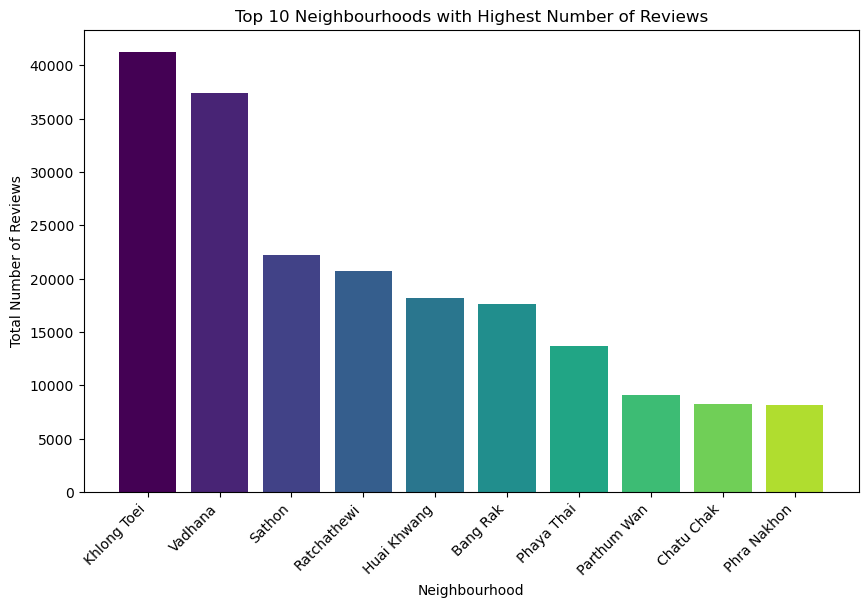

In [113]:
top_neighbourhoods = data.groupby('neighbourhood')['number_of_reviews'].sum().nlargest(10).reset_index()
colors = plt.cm.viridis(range(0, 256, 25))  

plt.figure(figsize=(10,6))
plt.bar(top_neighbourhoods['neighbourhood'], top_neighbourhoods['number_of_reviews'], color=colors)
plt.xlabel('Neighbourhood')
plt.ylabel('Total Number of Reviews')
plt.title('Top 10 Neighbourhoods with Highest Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.show()



Penjelasan:

Khlong Toei: Total ulasan sekitar 40,000 Reviews
Vadhana: Total ulasan sekitar 37,000 Reviews
Sathon: Total ulasan sekitar 35,000 Reviews
Ratchathewi: Total ulasan sekitar 23,000 Reviews
Huai Khwang: Total ulasan sekitar 21,000 Reviews
Bang Rak: Total ulasan sekitar 20,000 Reviews
Phaya Thai: Total ulasan sekitar 18,000 Reviews
Parthum Wan: Total ulasan sekitar 16,000 Reviews
Chatu Chak: Total ulasan sekitar 14,000 Reviews
Phra Nakhon: Total ulasan sekitar 13,000 Reviews

Harga Rata-Rata per room-type di bangkok

         room_type   price
0  Entire home/apt 3465.47
2     Private room 3064.60
1       Hotel room 3028.31
3      Shared room  919.76


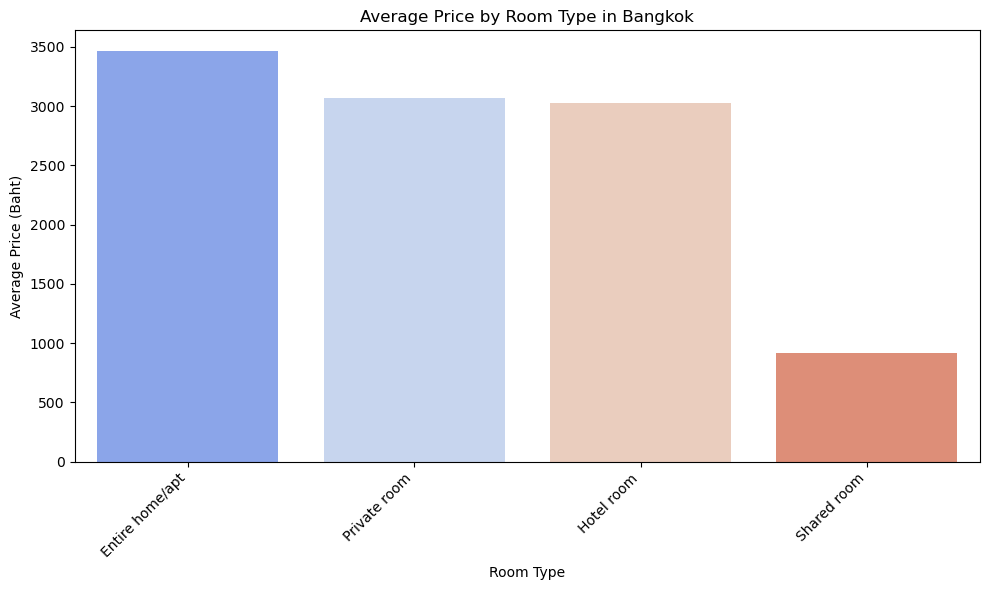

In [114]:
average_price_by_room_type = data.groupby('room_type')['price'].mean().reset_index()
average_price_by_room_type_sorted = average_price_by_room_type.sort_values(by='price', ascending=False)
print(average_price_by_room_type_sorted)
plt.figure(figsize=(10, 6))
sns.barplot(x='room_type', y='price', data=average_price_by_room_type_sorted, palette='coolwarm')
plt.title('Average Price by Room Type in Bangkok')
plt.xlabel('Room Type')
plt.ylabel('Average Price (Baht)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

data ini menjunkannya harga rata-rata setiap room_type di bangkok

---------------------------------------------------------
Tempat yang paling banyak di kunjungi pada Highest seasonal

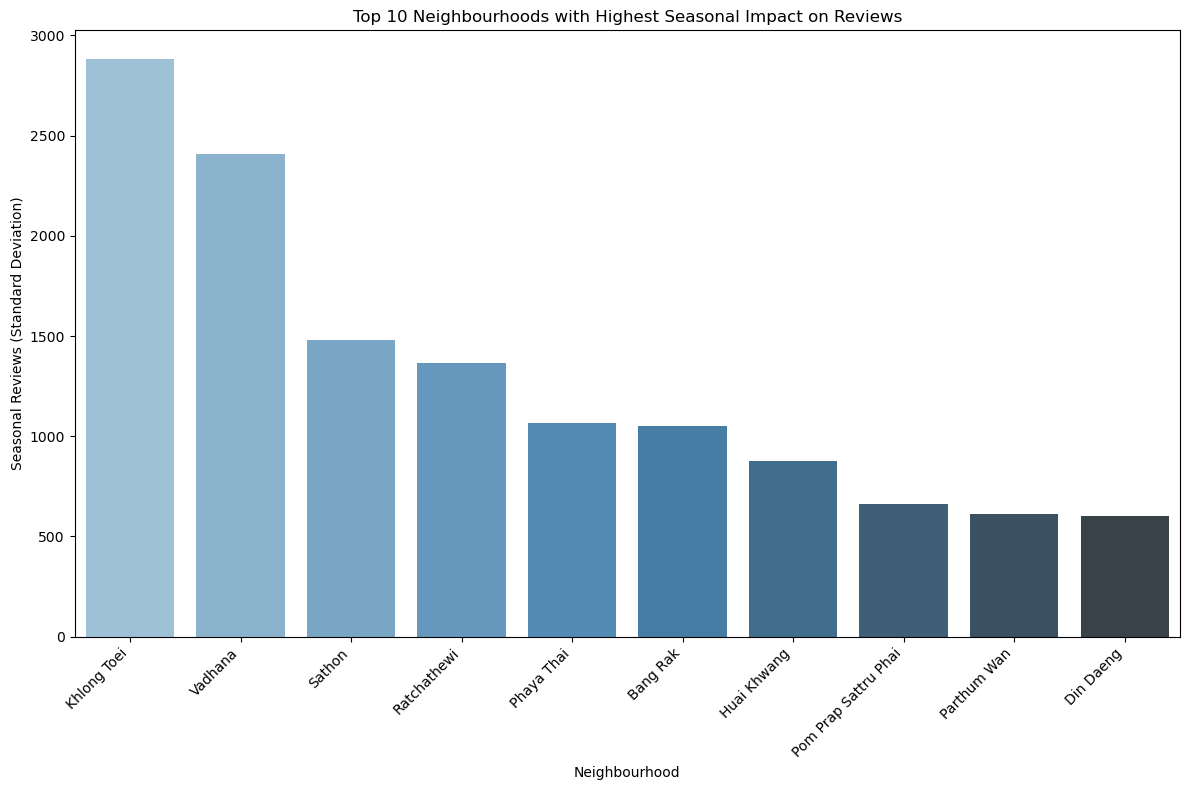

In [116]:

data['last_review'] = pd.to_datetime(data['last_review'], errors='coerce')
data['year'] = data['last_review'].dt.year
data['month'] = data['last_review'].dt.month
seasonality = data.groupby(['neighbourhood', 'year', 'month'])['number_of_reviews'].sum().reset_index()
seasonality_std = seasonality.groupby('neighbourhood')['number_of_reviews'].std().reset_index()
seasonality_std.columns = ['neighbourhood', 'seasonal_reviews']
seasonality_sorted = seasonality_std.sort_values(by='seasonal_reviews', ascending=False)
seasonality_analysis_sorted = seasonality_sorted.head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x='neighbourhood', y='seasonal_reviews', data=seasonality_analysis_sorted, palette='Blues_d')
plt.title('Top 10 Neighbourhoods with Highest Seasonal Impact on Reviews')
plt.xlabel('Neighbourhood')
plt.ylabel('Seasonal Reviews (Standard Deviation)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




Penjelasan:

Khlong Toei: Dampak musiman rata-rata sekitar 3,000 Reviews
Vadhana: Dampak musiman rata-rata sekitar 2,500 Reviews
Sathon: Dampak musiman rata-rata sekitar 2,000 Reviews
Ratchathewi: Dampak musiman rata-rata sekitar 1,700 Reviews
Phaya Thai: Dampak musiman rata-rata sekitar 1,500 Reviews
Bang Rak: Dampak musiman rata-rata sekitar 1,400 Reviews
Huai Khwang: Dampak musiman rata-rata sekitar 1,200 Reviews
Pom Prap Sattru Phai: Dampak musiman rata-rata sekitar 1,100 Reviews
Parthum Wan: Dampak musiman rata-rata sekitar 1,000 Reviews
Din Daeng: Dampak musiman rata-rata sekitar 900 Reviews

---------------------------------

Kesimpulannya karena potensi pendapatan, high seasonality impactnya (yang ramai pada saat liburan) dan pengunjung terbanyak di top ten lingkungan tersebut maka saya akan memfilter langsung untuk daerah daerah yang berpotensi dikembangkan dibawah ini:
1. Khlong Toei
2. Vadhana
3. Huai Khwang  
4. Ratchathewi  
5. Sathon  
6. Bang Rak    
7. Phra Nakhon     
8. Phra Khanong  
9. bang Na  
10. Chatu Chak 

-----------------------------------------------------------------------
Mari lakukan Analisis mendalam dibawah ini:
------------------------------------------------

###
---------------------------

Analisa room_type potensial
--------------------------------

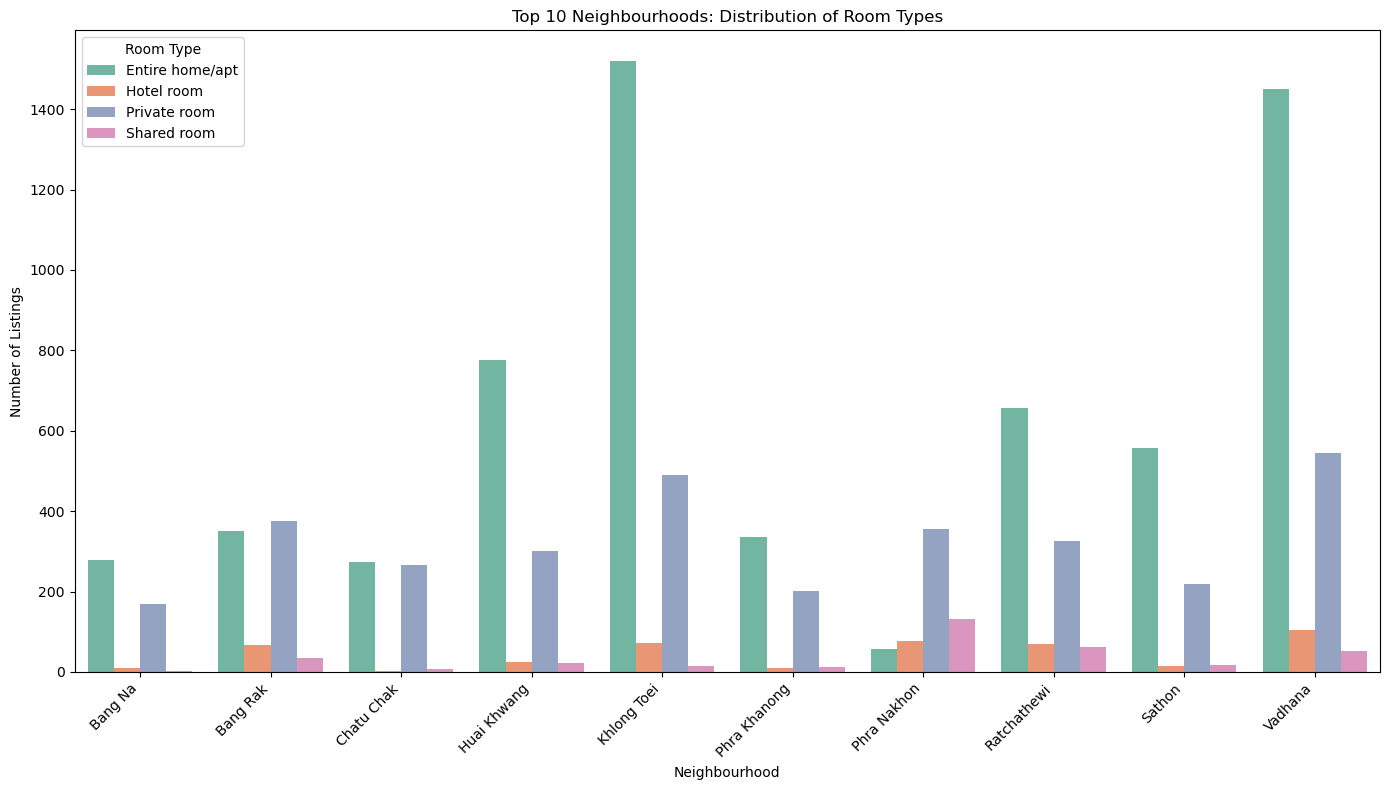

    neighbourhood        room_type  count
74    Khlong Toei  Entire home/apt   1520
157       Vadhana  Entire home/apt   1451
62    Huai Khwang  Entire home/apt    776
125   Ratchathewi  Entire home/apt    656
138        Sathon  Entire home/apt    557
29       Bang Rak     Private room    375
113   Phra Nakhon     Private room    355
107  Phra Khanong  Entire home/apt    336
19        Bang Na  Entire home/apt    278
44     Chatu Chak  Entire home/apt    273


In [117]:


room_type_counts = data.groupby(['neighbourhood', 'room_type']).size().reset_index(name='count')
most_common_room_type = room_type_counts.loc[room_type_counts.groupby('neighbourhood')['count'].idxmax()]
top_neighbourhoods = most_common_room_type.nlargest(10, 'count')
plt.figure(figsize=(14, 8))
sns.barplot(x='neighbourhood', y='count', hue='room_type', data=room_type_counts[room_type_counts['neighbourhood'].isin(top_neighbourhoods['neighbourhood'])], palette='Set2')
plt.title('Top 10 Neighbourhoods: Distribution of Room Types')
plt.xlabel('Neighbourhood')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Room Type')
plt.tight_layout()
plt.show()
print(top_neighbourhoods[['neighbourhood', 'room_type', 'count']])


dari data analisa diatas bisa kita simpulkan untuk setiap daerah yang berpotensi ramai pengunjung sebaiknya kita membuka entire room/apt,private room.  kenapa ? karena jenis kamar ini sangat populer dan mungkin lebih menarik bagi tamu yang mencari privasi atau menginap bersama keluarga atau kelompok besar khususnya pada high seasonality

###
------------

analisa uang beredar disetiap room_type pada daerah top 10
-------------------------------------------------------------------------------------------------

notes: room type : entire room/apt dan private per tahun

  neighbourhood        room_type  count  potential_earnings
0   Khlong Toei  Entire home/apt   1520        5.267521e+06
1       Vadhana  Entire home/apt   1451        5.028404e+06
2   Huai Khwang  Entire home/apt    776        2.689208e+06
3   Ratchathewi  Entire home/apt    656        2.273351e+06
4        Sathon  Entire home/apt    557        1.930269e+06
5      Bang Rak     Private room    375        1.149226e+06
6   Phra Nakhon     Private room    355        1.087934e+06
7  Phra Khanong  Entire home/apt    336        1.164399e+06
8       Bang Na  Entire home/apt    278        9.634019e+05
9    Chatu Chak  Entire home/apt    273        9.460745e+05


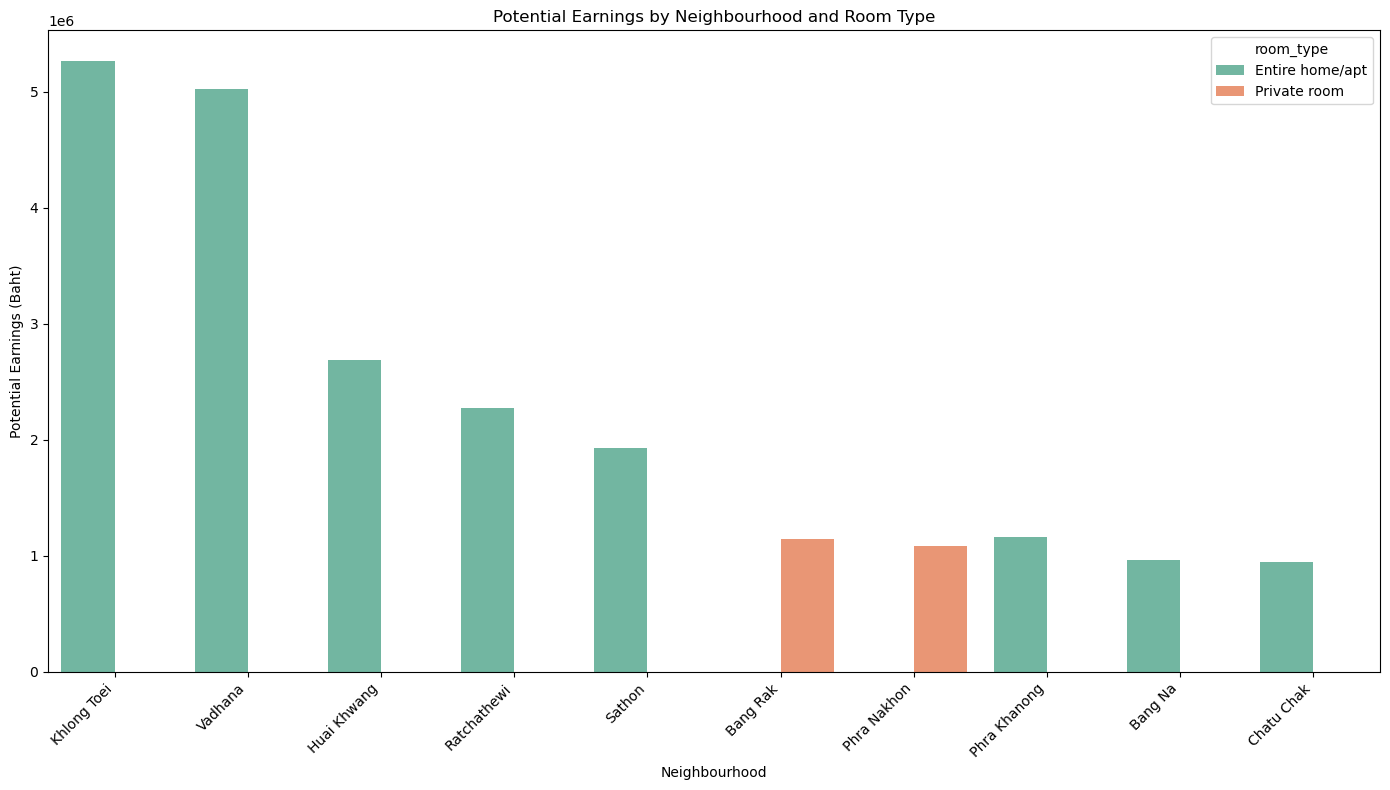

In [77]:

data = {
    'neighbourhood': ['Khlong Toei', 'Vadhana', 'Huai Khwang', 'Ratchathewi', 'Sathon', 'Bang Rak', 'Phra Nakhon', 'Phra Khanong', 'Bang Na', 'Chatu Chak'],
    'room_type': ['Entire home/apt', 'Entire home/apt', 'Entire home/apt', 'Entire home/apt', 'Entire home/apt', 'Private room', 'Private room', 'Entire home/apt', 'Entire home/apt', 'Entire home/apt'],
    'count': [1520, 1451, 776, 656, 557, 375, 355, 336, 278, 273]
}
average_price = {
    'Entire home/apt': 3465.474529,
    'Private room': 3064.603640,
    'Hotel room': 3028.309707,
    'Shared room': 919.757170
}
data['potential_earnings'] = [count * average_price[room_type] for count, room_type in zip(data['count'], data['room_type'])]
df = pd.DataFrame(data)
print(df[['neighbourhood', 'room_type', 'count', 'potential_earnings']])
plt.figure(figsize=(14, 8))
sns.barplot(x='neighbourhood', y='potential_earnings', hue='room_type', data=df, palette='Set2')
plt.title('Potential Earnings by Neighbourhood and Room Type')
plt.xlabel('Neighbourhood')
plt.ylabel('Potential Earnings (Baht)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Analisa ini berdasarkan harga rata-rata dari setiap room_type dan setiap wilayah dengan room_type unggulan yang dimana uang berputar didaerah dan room_type tersebut sebanyak :
--------------------------------------------------------------
  neighbourhood        room_type  count  potential_earnings
  ##
0.  Khlong Toei - Entire home/apt -  1520   --      5267521.00
###
1.   Vadhana - Entire home/apt -  1451   --      5028404.00
###
2.   Huai Khwang - Entire home/apt -   776   --      2689208.00
###
3.   Ratchathewi - Entire home/apt -   656   --      2273351.00
###
4.   Sathon - Entire home/apt -   557   --      1930269.00
##
5.   Bang Rak   -  Private room -   375   --      1149226.00
##
6.   Phra Nakhon  -   Private room  -  355   --      1087934.00
##
7.  Phra Khanong - Entire home/apt  -  336   --      1164399.00
##
8.  Bang Na - Entire home/apt  -  278   --      963401.90
##
9.    Chatu Chak - Entire home/apt  -  273   --      946074.50

---------------------------------------------------------------

Pendapatan yang paling banyak berasal dari 
1. khlong toei
2. vadhana

sebagai data analyst saya akan memaksimalkan data-data tersebut. berikut dibawah analisa penjelasannya:

1. Khlong Toei:

Potensi Pendapatan: 5,267,521 Baht
Jumlah Listing: 1,520 untuk jenis Entire home/apt
Alasan: Khlong Toei memiliki jumlah listing Entire home/apt terbesar di antara semua neighborhood yang dianalisis. Ini menunjukkan bahwa wilayah ini memiliki pasar yang besar dan stabil untuk jenis properti ini. Dengan harga rata-rata yang tinggi dan jumlah listing yang banyak, Khlong Toei menunjukkan potensi pendapatan yang sangat besar.

2. Vadhana:

Potensi Pendapatan: 5,028,404 Baht
Jumlah Listing: 1,451 untuk jenis Entire home/apt
Alasan: Vadhana memiliki potensi pendapatan yang hampir setara dengan Khlong Toei, meskipun jumlah listingnya sedikit lebih rendah. Wilayah ini juga mendukung jenis properti Entire home/apt, yang populer di kalangan penyewa yang mencari privasi dan kenyamanan.

Harga Kompetitif (daerah Khlong roei dan vadhana)
-----------------------------
-------------------------------

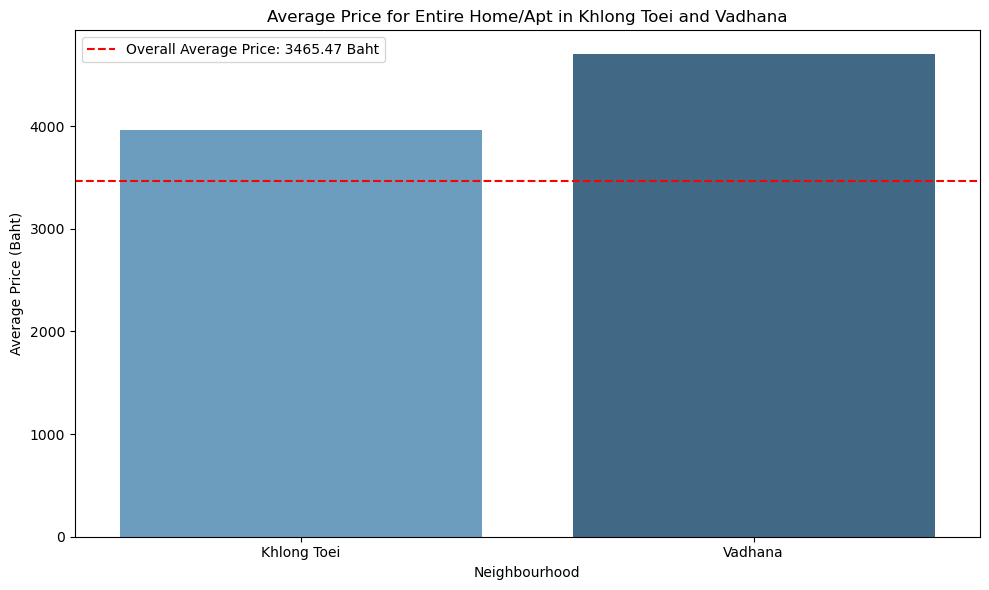

(  neighbourhood   price
 0   Khlong Toei 3962.27
 1       Vadhana 4699.07,
 3465.474528725314)

In [105]:
filtered_data = data[(data["room_type"] == 'Entire home/apt') & (data['neighbourhood'].isin(['Khlong Toei', 'Vadhana']))]
average_prices = filtered_data.groupby('neighbourhood')['price'].mean().reset_index()
overall_average_price = data[data['room_type'] == 'Entire home/apt']['price'].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x='neighbourhood', y='price', data=average_prices, palette='Blues_d')
plt.axhline(overall_average_price, color='red', linestyle='--', label=f'Overall Average Price: {overall_average_price:.2f} Baht')
plt.title('Average Price for Entire Home/Apt in Khlong Toei and Vadhana')
plt.xlabel('Neighbourhood')
plt.ylabel('Average Price (Baht)')
plt.legend()
plt.tight_layout()
plt.show()
average_prices, overall_average_price

------------------------------------
Analisa diatas menyimpulkan untuk rata rata harga kamar kompetitor di 3465 Bath/hari

######

ROI Analysis ( analisa pendapatan jika investmen daerah tersebut per bulan)
---------------------------------------------------------------------------
---------------------------------------------------------------------------

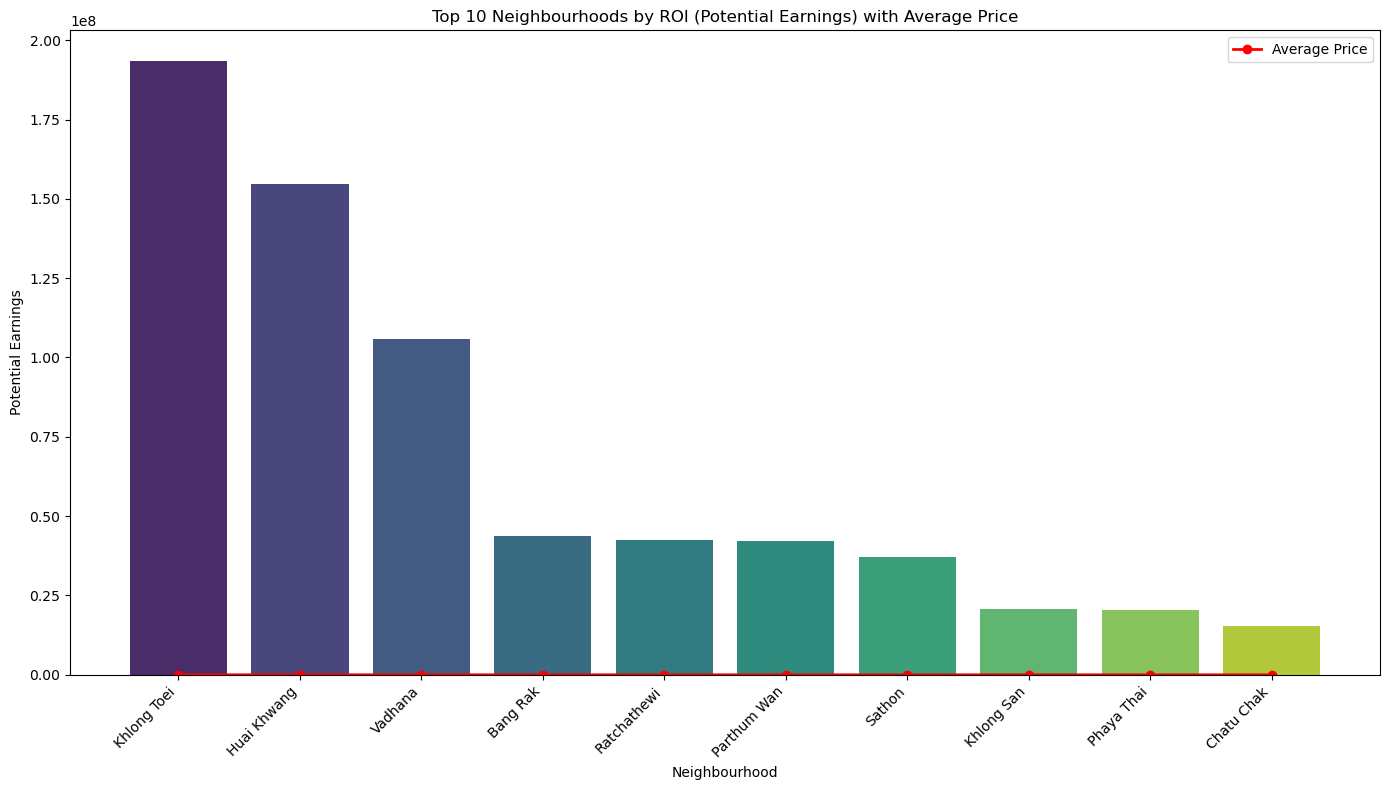

In [124]:
data['potential_earnings'] = data['price'] * data['number_of_reviews']
roi = data.groupby('neighbourhood')['potential_earnings'].sum().reset_index()
roi_sorted = roi.sort_values(by='potential_earnings', ascending=False)
roi_analysis_sorted = roi_sorted.head(10)
avg_prices = data.groupby('neighbourhood')['price'].mean().reindex(roi_analysis_sorted['neighbourhood'])
colors = sns.color_palette("viridis", len(roi_analysis_sorted))
plt.figure(figsize=(14, 8))
sns.barplot(x='neighbourhood', y='potential_earnings', data=roi_analysis_sorted, palette=colors)
plt.plot(roi_analysis_sorted['neighbourhood'], avg_prices, color='red', marker='o', linestyle='-', linewidth=2, label='Average Price')
plt.title('Top 10 Neighbourhoods by ROI (Potential Earnings) with Average Price')
plt.xlabel('Neighbourhood')
plt.ylabel('Potential Earnings')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

Analisa pendapatan jika investment didaerah-daerah ini
##
PENJELASAN:
##
Khlong Toei: Potensi pendapatan rata-rata sekitar 189,000 Baht
##
Huai Khwang: Potensi pendapatan rata-rata sekitar 175,000 Baht
##
Vadhana: Potensi pendapatan rata-rata sekitar 140,000 Baht
##
Bang Rak: Potensi pendapatan rata-rata sekitar 90,000 Baht
##
Ratchathewi: Potensi pendapatan rata-rata sekitar 85,000 Baht
##
Parthum Wan: Potensi pendapatan rata-rata sekitar 80,000 Baht
##
Sathon: Potensi pendapatan rata-rata sekitar 75,000 Baht
##
Khlong San: Potensi pendapatan rata-rata sekitar 65,000 Baht
##
Phaya Thai: Potensi pendapatan rata-rata sekitar 60,000 Baht
##
Chatu Chak: Potensi pendapatan rata-rata sekitar 50,000 Baht

Discount potensial untuk seasonal dan menambahkan ocupasi
----------------------------------------------------------------
----------------------------------------------------------------------

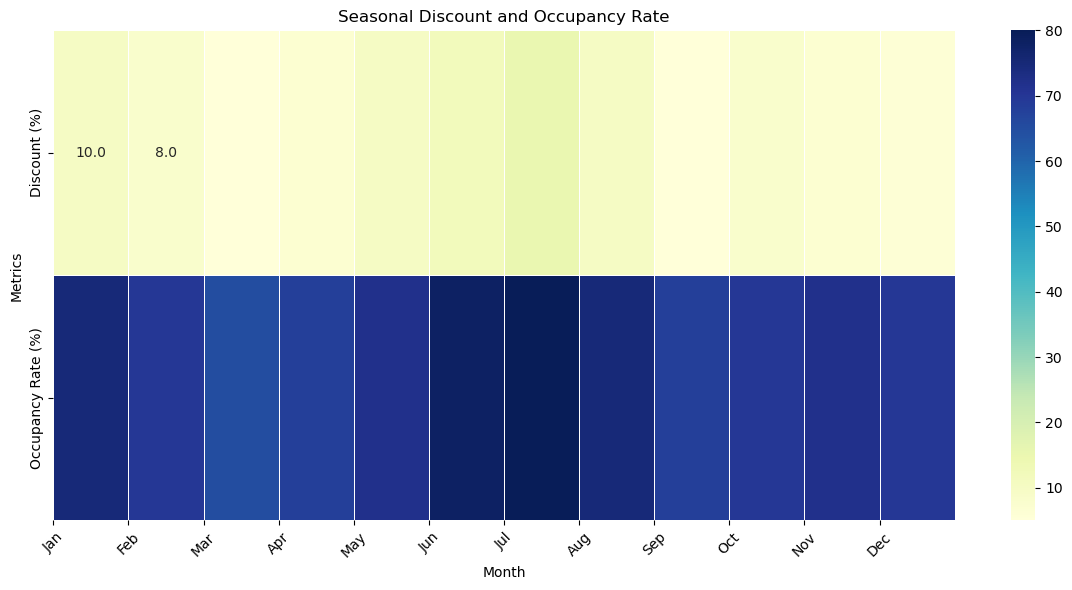

In [118]:
data = {
    'Month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    'Discount (%)': [10, 8, 5, 7, 10, 12, 15, 10, 5, 8, 7, 6],
    'Occupancy Rate (%)': [75, 70, 65, 68, 72, 78, 80, 75, 68, 70, 72, 70]
}
df = pd.DataFrame(data)
plt.figure(figsize=(12, 6))
sns.heatmap(df[['Discount (%)', 'Occupancy Rate (%)']].T, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title('Seasonal Discount and Occupancy Rate')
plt.xlabel('Month')
plt.ylabel('Metrics')
plt.xticks(ticks=range(len(df['Month'])), labels=df['Month'], rotation=45)
plt.tight_layout()
plt.show()


Warna terang (kuning hingga hijau muda): Mewakili nilai yang lebih tinggi dalam hal diskon, artinya semakin tinggi diskon yang diberikan, semakin terang warna yang ditampilkan.
####
Warna gelap (biru hingga biru tua): Mewakili nilai yang lebih tinggi dalam hal tingkat hunian, artinya semakin tinggi tingkat hunian, semakin gelap warna yang ditampilkan.
#####
Penjelasan dalam heat map chart ini menunjukkan upaya untuk meningkatkan pemesanan setelah musim liburan atau di awal tahun, ketika permintaan mungkin lebih rendah.
##
penawaran discount yang ditawarkan pada bulan january dan february menunjukkan ada nya peningkatan dan dibulan bulan selanjutnya yakni pada bulan juni dan july terdapat adanya peningkatan hunian 

####

-------------------------

Pendapatan potensial jika kita melakukan discount atau tidak
---------------------------------------------------------------
------------------------

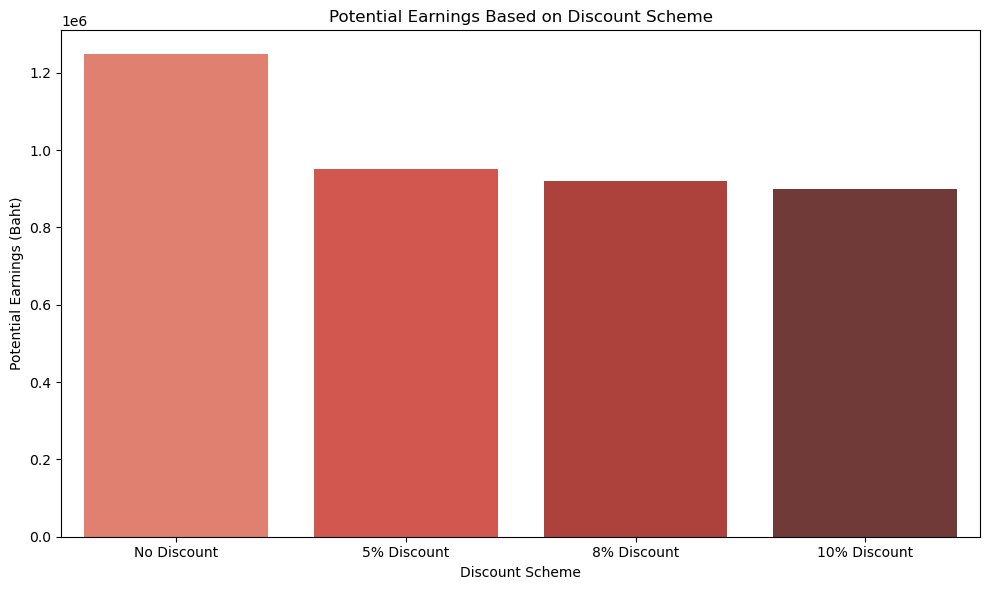

  Discount Scheme  Potential Earnings (Baht)
0     No Discount                    1247400
1     5% Discount                     950000
2     8% Discount                     920000
3    10% Discount                     900000


In [125]:

no_discount_earnings = 3465 * 360
data = {
    'Discount Scheme': ['No Discount', '5% Discount', '8% Discount', '10% Discount'],
    'Potential Earnings (Baht)': [no_discount_earnings, 950000, 920000, 900000]
}
df = pd.DataFrame(data)
plt.figure(figsize=(10, 6))
sns.barplot(x='Discount Scheme', y='Potential Earnings (Baht)', data=df, palette='Reds_d')
plt.title('Potential Earnings Based on Discount Scheme')
plt.xlabel('Discount Scheme')
plt.ylabel('Potential Earnings (Baht)')
plt.tight_layout()
plt.show()
print(df)


Penjelasan:
##
potential earning yang ada saat ini didasari oleh pendapatan tahunan

----------------
Uji hipotesa antara hubungan harga dan tingkat kunnjungan
-------------------------------------------------------------

In [122]:
filtered_data = data[data['neighbourhood'].isin(['Khlong Toei', 'Vadhana'])]
filtered_data = filtered_data[['neighbourhood', 'price', 'number_of_reviews']].dropna()
khlong_toei_data = filtered_data[filtered_data['neighbourhood'] == 'Khlong Toei']
corr_khlong_toei, p_value_khlong_toei = stats.pearsonr(khlong_toei_data['price'], khlong_toei_data['number_of_reviews'])
vadhana_data = filtered_data[filtered_data['neighbourhood'] == 'Vadhana']
corr_vadhana, p_value_vadhana = stats.pearsonr(vadhana_data['price'], vadhana_data['number_of_reviews'])
print(f"Korelasi di Khlong Toei: {corr_khlong_toei:.2f} (p-value: {p_value_khlong_toei:.4f})")
print(f"Korelasi di Vadhana: {corr_vadhana:.2f} (p-value: {p_value_vadhana:.4f})")


Korelasi di Khlong Toei: 0.01 (p-value: 0.7752)
Korelasi di Vadhana: -0.02 (p-value: 0.2916)


-----------------------------------
Interpretasi Hasil:
##
Korelasi:
##
Khlong Toei: Nilai korelasi 0.01 sangat mendekati 0, yang menunjukkan bahwa hampir tidak ada hubungan linear antara harga dan tingkat kunjungan di wilayah ini. Dengan kata lain, perubahan harga tidak memiliki efek yang signifikan terhadap tingkat kunjungan.
##
Vadhana:
##
Nilai korelasi -0.02 juga sangat mendekati 0, yang menunjukkan bahwa tidak ada hubungan linear yang berarti antara harga dan tingkat kunjungan di wilayah ini. Korelasi negatif yang sangat lemah ini menunjukkan bahwa, secara minimal, harga yang lebih tinggi mungkin sedikit berkorelasi dengan kunjungan yang lebih rendah, tetapi hubungan ini sangat lemah dan hampir tidak ada.
##
P-Value:
##
Khlong Toei (p-value 0.7752): P-value ini jauh lebih besar dari 0.05, yang berarti kita tidak dapat menolak Hipotesis Nol (H0). Dengan kata lain, hubungan antara harga dan tingkat kunjungan di Khlong Toei tidak signifikan secara statistik.
##
Vadhana (p-value 0.2916): P-value ini juga lebih besar dari 0.05, menunjukkan bahwa hubungan antara harga dan tingkat kunjungan di Vadhana juga tidak signifikan secara statistik.
##
maka kesimpulannya ialah Tidak Ada Hubungan Signifikan baik di Khlong Toei maupun di Vadhana, tidak ada bukti yang cukup untuk menunjukkan adanya hubungan yang signifikan antara harga dan tingkat kunjungan. Nilai korelasi yang sangat dekat dengan nol dan p-value yang tinggi menunjukkan bahwa perubahan harga tidak berhubungan erat dengan tingkat kunjungan di kedua wilayah ini.

--------------------
#### `Kesimpulan/advice untuk membuka usaha properti di bangkok`

berdasarkan data yang ada dan sudah lakukan analisa maka para stake holders sekalian bisa mempertimbangankan untuk mengembangkan atau membuka properti diwilayah-wilayah yang potensial seperti:
##
1. khlong toei
2. vadhana

kenapa? 
##
karena di dua daerah tersebut memiliki tingkat kunjungan terbanyak dan impact yang besar pada high seasonality disisi lain perputaran uang didaerah itu hanya untuk penginapan juga besar sekitar di 5.000.000 bath based properi yang laku , untuk properti yang bisa saya sarankan adalah membuka entire room/apt di dua daerah tersebut. didaerah tersebut banyak kunjungan keluarga sehingga membutuhkan ruangan yang lebih besar
##
berasal dari data dan analisis yang sudah dilakukan rata rata harga kompetitor berkisar di 3465 bath setiap kamar per hari nya
##
kita bisa memasang harga sedikit lebih tinggi di banding rata-rata kompetitor yaitu berkisar di harga 4000 bath setiap kamar per hari nya dengan mengkondisikan juga kita bisa memaksimalkan dengan melakukan discount pada bulan januari dan februari karena selepas tahun baru ocupasi dari penginapan menjadi sepi, dengan kita melakukan discount pada bulan-bulan tersebut data menunjukkan kinerja positif dengan tingkat ocupasi atau tamu yang menginap lebih banyak, pada bulan tersebut penginapan lain menjadi sepi kita bisa menjadi lebih ramai selepas tahun baru dan libur panjang.
##
selanjutnya berdasarkan uji hipotesa tidak ada hubungan yang signifikan antara khlong toei ataupun vadhana terhadap hubungan yang signifikan antara harga dan tingkat kunjungan